In [ ]:
from keras.backend import deprecated_internal_set_learning_phase
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn import model_selection


drive.mount('/content/drive')
!pip install --upgrade openpyxl

Mounted at /content/drive


In [ ]:
measured_data = pd.read_excel("/content/drive/MyDrive/Dataset/2015_Data_Cleaned.xlsx")#, dtype={"Time":str})
reanalysis = pd.read_excel('/content/drive/MyDrive/Dataset/reanalysis_Cleaned.xlsx')

In [ ]:

#measured_data.head()


,Relative_Humidity,Temperature,Atmospheric_Pressure,Date,Time,Measured_Windspeed,Measured_Direction
0,87.6,5.78,1026,2015-01-01,00:00:00,10.94,227.9
1,87.6,5.76,1026,2015-01-01,00:01:00,10.49,231.5
2,87.9,5.80,1026,2015-01-01,00:02:00,11.13,224.8
3,87.3,5.80,1026,2015-01-01,00:03:00,9.87,230.3
4,87.7,5.76,1026,2015-01-01,00:04:00,10.75,232.8


In [ ]:
from sklearn.impute import SimpleImputer

def imputation(df):
    dfs=df
    df=df.drop(['Date'],axis=1)
    #df=df.drop(['Datet'],axis=1)
    df=df.drop(['Time'],axis=1)
    df = df.replace([9999.99],np.nan)
    imp = SimpleImputer(strategy='mean')
    df=df.dropna(axis=0)
    df_mat = imp.fit_transform(df.values)
    df = pd.DataFrame(df_mat, index=df.index, columns=df.columns)
    df['Date']=dfs['Date']
    #df['Datet']=dfs['Datet']
    df['Time']=dfs['Time']
    return df

def data_org(df):
    #df['Date']=df['Date'].dt.strftime('%Y-%m-%d')    
    #replace nans with average of numbers around it
    #df=df.replace(9999.99,np.nan)
    #df=df.dropna(axis=0)    
    return df, X,Y

def scale_data(df):
    df["Date"] = [float(str(i).replace("-", "")) for i in df["Date"]]
    df["Time"] = [float(str(i).replace(":", "")) for i in df["Time"]]
    print(df.head())
    #df['Datet'] = df['Date']  + df['Time']
    X = df[['Date','Time','Relative_Humidity','Temperature','Atmospheric_Pressure','Measured_Direction']]      
    Y = df[['Measured_Windspeed']]
    #X_train, X_test ,Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=None)      
    split=0.7    
    X_train, X_test = X[0:int(len(X)*split)], X[-int(len(X)*(1-split)):]
    Y_train, Y_test = Y[0:int(len(Y)*split)], Y[-int(len(Y)*(1-split)):]
    return X_train,X_test,Y_train,Y_test


if __name__ == '__main__':   

    df=imputation(measured_data) # imputing data
   # df,X,Y=data_org(df) #  organising 
    
    X_train,X_test,Y_train,Y_test=scale_data(df)     
    xnorm = StandardScaler();
    ynorm = StandardScaler();
    X_train=xnorm.fit_transform(X_train)    
    X_test=xnorm.transform(X_test)
    Y_train=ynorm.fit_transform(np.array(Y_train).reshape(-1,1))
    Y_test=ynorm.transform(np.array(Y_test).reshape(-1,1))
    #Minmax scalar- scaling data between 0 and 1
    X_train=X_train.reshape(len(X_train),1,6)
    X_test=X_test.reshape(len(X_test),1,6)
    Y_train = Y_train.reshape(len(Y_train),1,1)
    Y_test = Y_test.reshape(len(Y_test),1,1)

    #20% validation
    val_split=0.2
    X_trainx,X_val,Y_trainy,Y_val=train_test_split(X_train,Y_train,test_size=val_split)
  
    #try altering learning rate
    model = Sequential()
    model.add(LSTM(6, input_shape=(1,6), activation='relu',return_sequences=True))
    #model.add(Dense(25, activation='tanh'))
    #model.add(Dense(20, activation='tanh'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))


    opt = keras.optimizers.Adam(learning_rate=0.0005)
    history=model.compile(optimizer=opt,loss='mean_squared_error')
    print(model.summary())
    history=model.fit(X_train,Y_train,validation_data=(X_val, Y_val), epochs=100, batch_size=32)
    # predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    trainPredict=trainPredict.reshape(len(trainPredict),1)
    testPredict=testPredict.reshape(len(testPredict),1)
    

    import math
    print(' ')
    trainingScore = model.evaluate(X_train, Y_train)
    print('Training Score is : %.3f MSE (%.3f RMSE)' % (trainingScore, math.sqrt(trainingScore)))
    testingScore = model.evaluate(X_test, Y_test)
    print('Testing Score is  : %.3f MSE (%.3f RMSE)' % (testingScore, math.sqrt(testingScore)))

    X_train=X_train.reshape(len(X_train),6)
    X_test=X_test.reshape(len(X_test),6)
    Y_train = Y_train.reshape(len(Y_train),1)
    Y_test = Y_test.reshape(len(Y_test),1)
#create seperate data set which is one day behind

#create two columns X_train always one day behind Y_train, want to input today and predict tomorrow

      Relative_Humidity  Temperature  ...        Date      Time
997                81.8        13.61  ...  20020211.0  130000.0
998                80.8        13.92  ...  20020211.0  140000.0
999                84.4        13.21  ...  20020211.0  150000.0
1000               81.8        13.49  ...  20020211.0  160000.0
1001               78.9        13.27  ...  20020211.0  170000.0

[5 rows x 7 columns]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 6)              312       
                                                                 
 dense_23 (Dense)            (None, 1, 15)             105       
                                                                 
 dense_24 (Dense)            (None, 1, 10)             160       
                                                                 
 dense_25 (Dense)            (None, 1, 1)   

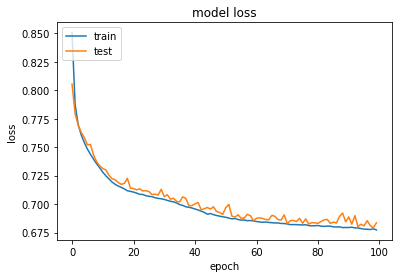

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

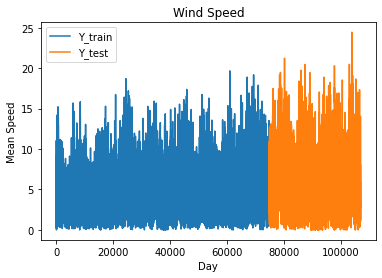

In [ ]:
#plt.plot(range(0,Y_train.shape[0]),Y_train,label='Y_train')
#plt.plot(range(Y_train.shape[0],Y_train.shape[0]+Y_test.shape[0]),testPredict, label='testPredict')

plt.plot(range(len(X_train)), ynorm.inverse_transform(Y_train),label='Y_train')
plt.plot(range(len(X_train), len(X_test) + len(X_train)), ynorm.inverse_transform(Y_test), label='Y_test')

plt.xlabel('Day')
plt.ylabel('Mean Speed')
plt.title('Wind Speed')
plt.legend()
plt.show()

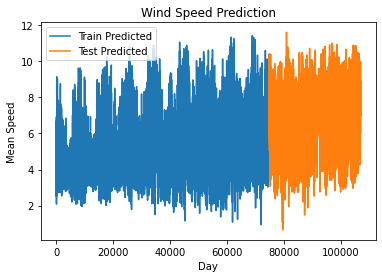

In [36]:
'''
plt.plot(range(len(Y_train)), ynorm.inverse_transform(Y_train),label='Y_train')
plt.plot(range(len(Y_train), len(Y_train) + len(testPredict)), ynorm.inverse_transform(testPredict), label='Test Predicted')
'''
plt.plot(range(len(Y_train)), ynorm.inverse_transform(trainPredict),label='Train Predicted')
plt.plot(range(len(Y_train), len(Y_train) + len(testPredict)), ynorm.inverse_transform(testPredict), label='Test Predicted')


plt.xlabel('Day')
plt.ylabel('Mean Speed')
plt.title('Wind Speed Prediction')
plt.legend()
plt.show()

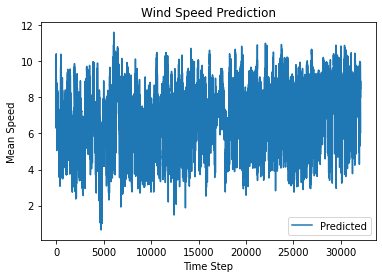

In [ ]:

plt.plot(range(len(testPredict)),  ynorm.inverse_transform(testPredict),label='Predicted')
#plt.plot(df.Datet, full_prediction,label='Predicted')

plt.xlabel('Time Step')
plt.ylabel('Mean Speed')
plt.title('Wind Speed Prediction')
plt.legend()
plt.show()